<a href="https://colab.research.google.com/github/guillotine46/skin-disease-detection-cnn/blob/main/Skin_Disease_Detection_Using_CNN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2.9.1


In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [ ]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values())
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
      plot_bar=[]
      plot_class=[]
      for  key, value in new_dict.items():
          count=error_indices.count(key)
          if count!=0:
              plot_bar.append(count)
              plot_class.append(value)
      fig=plt.figure()
      fig.set_figheight(len(plot_class)/3)
      fig.set_figwidth(10)
      plt.style.use('fivethirtyeight')
      for i in range(0, len(plot_class)):
          c=plot_class[i]
          x=plot_bar[i]
          plt.barh(c, x, )
          plt.title( ' Errors by Class on Test Set')
      y_true= np.array(labels)
      y_pred=np.array(y_pred)
      if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .05)
            fig_height= int(length * .05)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
      clr = classification_report(y_true, y_pred, target_names=classes)
      print("Classification Report:\n----------------------\n", clr)

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    class_dict=generator.class_indices
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class')
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc

In [ ]:
def predictor(sdir, csv_path,  model_path, crop_image = False):
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print ('Model is getting loaded - this will take some time')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
        if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[]
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(524, 720, 3)


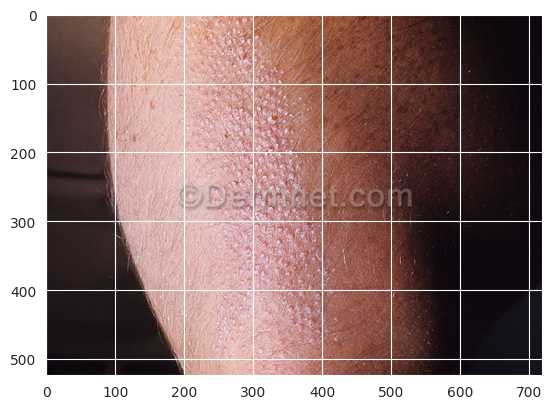

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
fpath=r'/content/gdrive/MyDrive/data/IMG_CLASSES/3. Atopic Dermatitis - 1.25k/v-KeratosisIMG004-GP3.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [ ]:
def splitdataset (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df

In [ ]:
sdir=r'/content/gdrive/MyDrive/data/IMG_CLASSES'
train_df, test_df, valid_df= splitdataset(sdir, .8,.1)

train_df length:  21722   test_df length:  2716   valid_df length:  2715
5. Melanocytic Nevi (NV) - 7970                                     6376
4. Basal Cell Carcinoma (BCC) 3323                                  2658
2. Melanoma 15.75k                                                  2512
10. Warts Molluscum and other Viral Infections - 2103               1682
6. Benign Keratosis-like Lesions (BKL) 2624                         1663
7. Psoriasis pictures Lichen Planus and related diseases - 2k       1644
8. Seborrheic Keratoses and other Benign Tumors - 1.8k              1477
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k    1362
1. Eczema 1677                                                      1342
3. Atopic Dermatitis - 1.25k                                        1006
Name: labels, dtype: int64


In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path)
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels')
    for label in train_df['labels'].unique():
        group=groups.get_group(label)
        sample_count=len(group)
        if sample_count< max_samples:
            aug_img_count=0
            delta=max_samples-sample_count
            target_dir=os.path.join(aug_dir, label)
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    print (list(ndf['labels'].value_counts()) )
    return ndf

In [ ]:
max_samples= 1006
min_samples=0
column='labels'
working_dir = r'./'
img_size=(300, 300)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]
[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]


<ipython-input-15-d0db879cc78f>:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Fseries=pd.Series(aug_fpaths, name='filepaths')
<ipython-input-15-d0db879cc78f>:38: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Lseries=pd.Series(aug_labels, name='labels')


In [ ]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  28   test steps:  97
Found 10060 validated image filenames belonging to 10 classes.
Found 2716 validated image filenames belonging to 10 classes.
Found 2715 validated image filenames belonging to 10 classes.


In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
epochs =10
history=model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
               validation_steps=None)

Epoch 1/10
336/336 [==============================] - 575s 2s/step - loss: 7.1737 - accuracy: 0.5000 - val_loss: 4.9678 - val_accuracy: 0.7238
Epoch 2/10
336/336 [==============================] - 319s 948ms/step - loss: 4.0168 - accuracy: 0.6592 - val_loss: 2.8736 - val_accuracy: 0.7562
Epoch 3/10
336/336 [==============================] - 318s 946ms/step - loss: 2.3783 - accuracy: 0.7360 - val_loss: 1.8006 - val_accuracy: 0.7750
Epoch 4/10
336/336 [==============================] - 318s 945ms/step - loss: 1.5142 - accuracy: 0.7922 - val_loss: 1.2350 - val_accuracy: 0.8026
Epoch 5/10
336/336 [==============================] - 320s 952ms/step - loss: 1.0653 - accuracy: 0.8380 - val_loss: 1.0271 - val_accuracy: 0.8063
Epoch 6/10
336/336 [==============================] - 319s 947ms/step - loss: 0.8053 - accuracy: 0.8829 - val_loss: 0.9308 - val_accuracy: 0.8144
Epoch 7/10
336/336 [==============================] - 320s 950ms/step - loss: 0.6581 - accuracy: 0.9060 - val_loss: 0.8933 - va

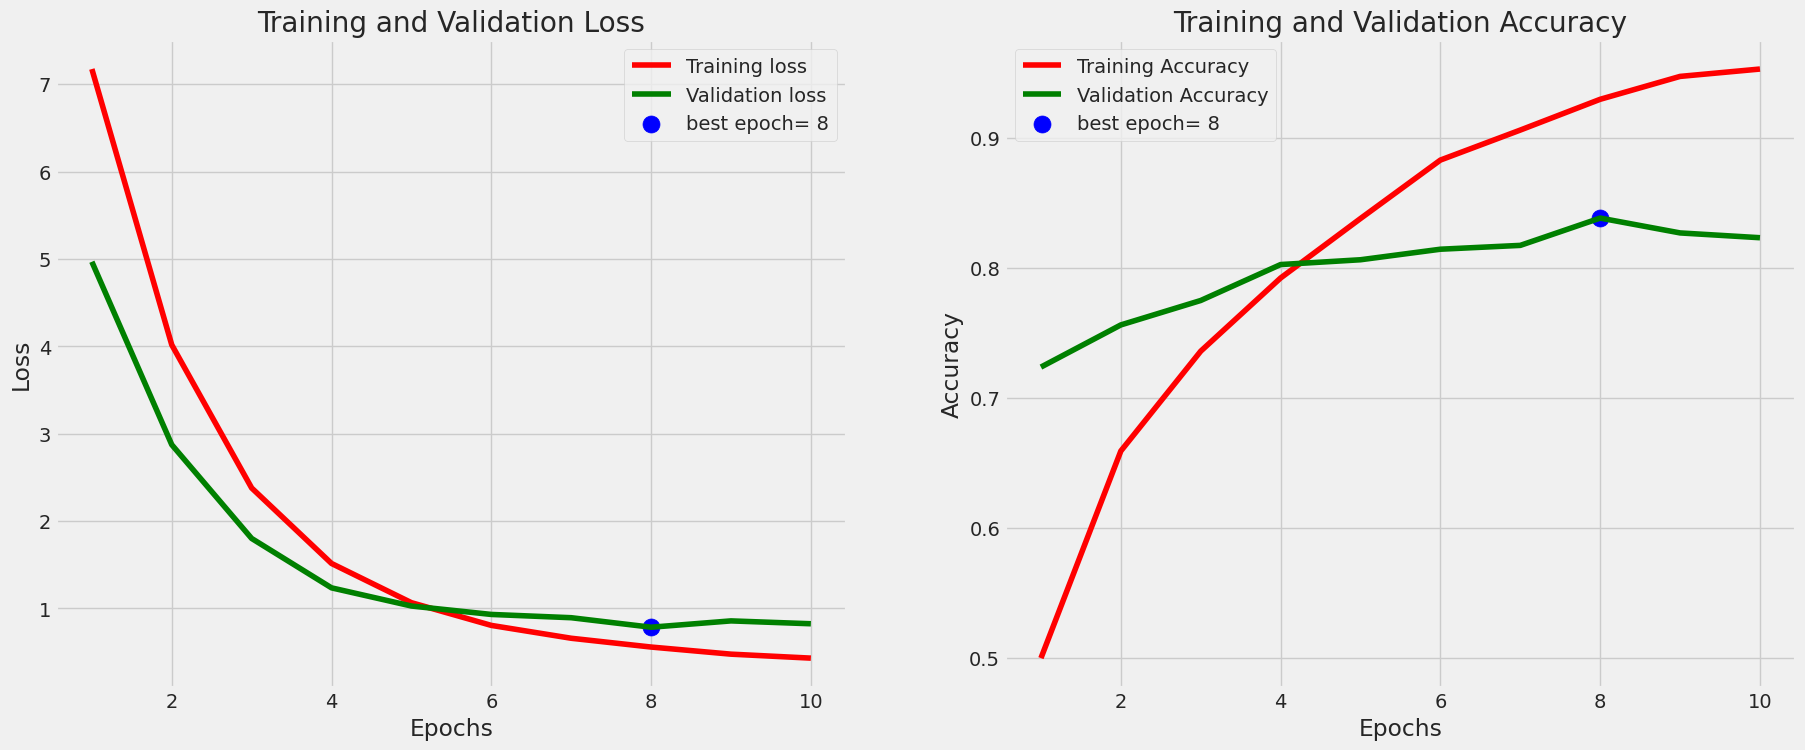

97/97 [==============================] - 1825s 19s/step - loss: 0.8474 - accuracy: 0.8141
accuracy on the test set is 81.41 %

model was saved as ./EfficientNetB3-skin disease-81.40.h5

class csv file was saved as ./class_dict.csv



In [ ]:
tr_plot(history,0)
subject='skin disease'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model.save_weights('model_weights.h5')
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

97/97 [==============================] - 53s 514ms/step


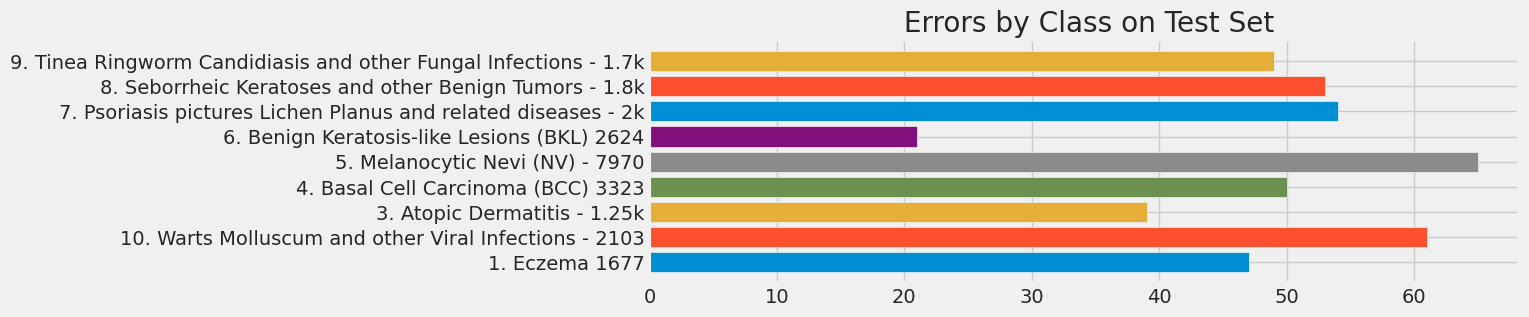

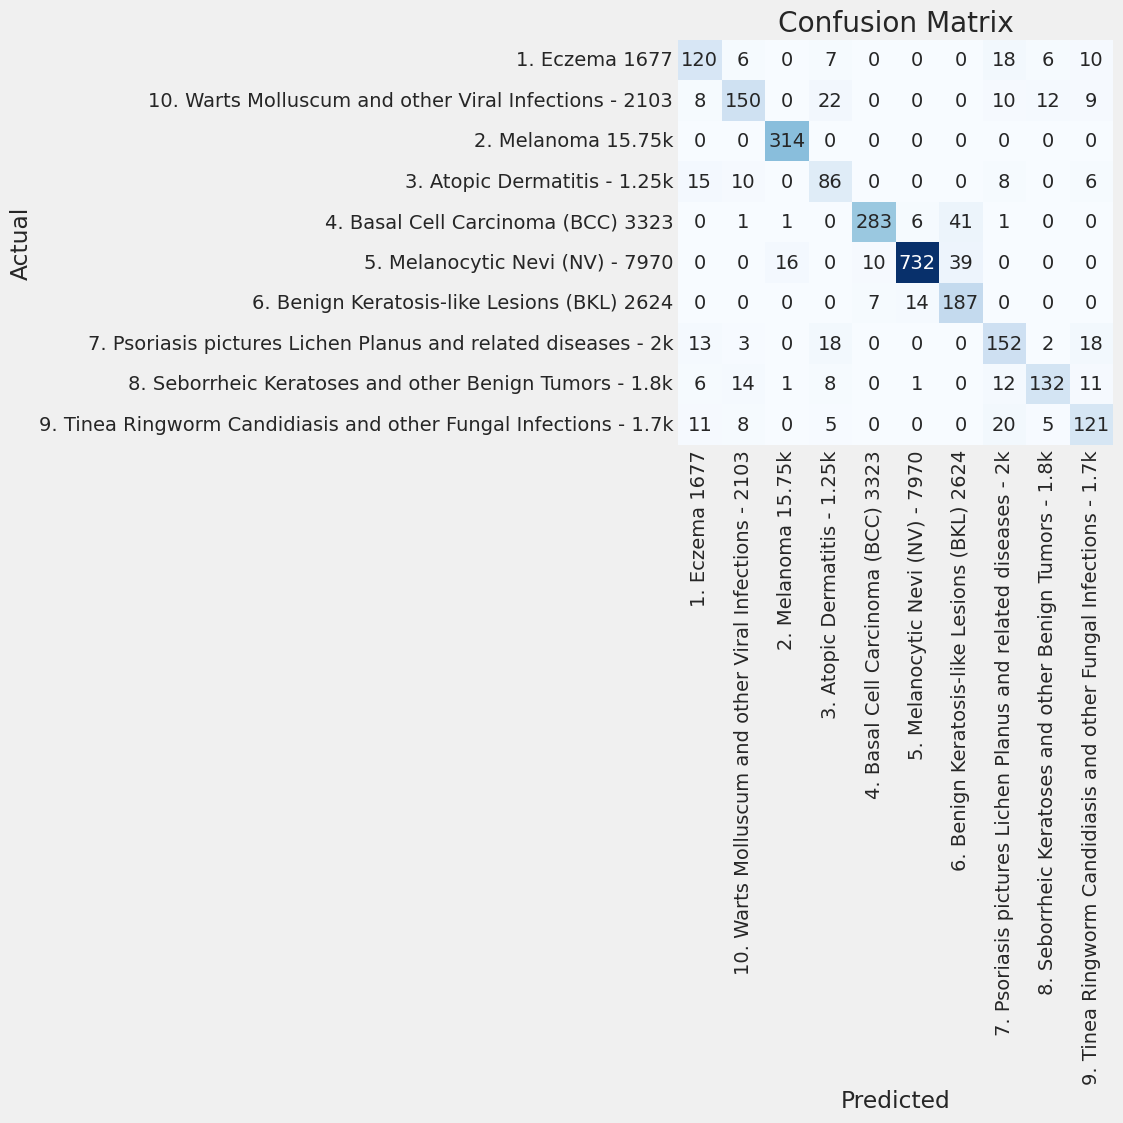

Classification Report:
----------------------
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.69      0.72      0.71       167
           10. Warts Molluscum and other Viral Infections - 2103       0.78      0.71      0.74       211
                                              2. Melanoma 15.75k       0.95      1.00      0.97       314
                                    3. Atopic Dermatitis - 1.25k       0.59      0.69      0.63       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.94      0.85      0.89       333
                                 5. Melanocytic Nevi (NV) - 7970       0.97      0.92      0.94       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.70      0.90      0.79       208
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.69      0.74      0.71       20

In [ ]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1)
print_info( test_gen, preds, print_code, working_dir, subject )

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Psoriasis pictures Lichen Planus and related diseases/08SebDermLids030104.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['08SebDermLids030104.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class:  Psoriasis pictures Lichen Planus and related diseases
Probability:  96.24 %



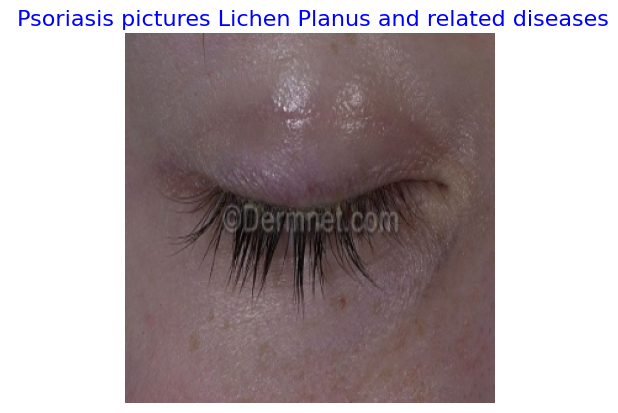

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Eczema Photos/eczema-arms-4.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['eczema-arms-4.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Eczema
Probability:  98.34 %



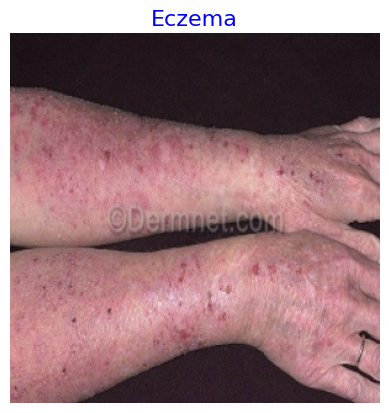

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Melanoma Skin Cancer Nevi and Moles/malignant-melanoma-118.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['malignant-melanoma-118.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Melanocytic Nevi
Probability:  37.38 %



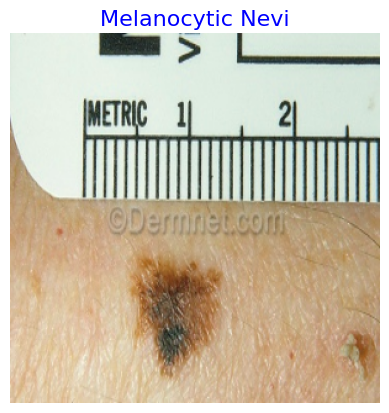

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Warts Molluscum and other Viral Infections/12wartCommon0403061.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['12wartCommon0403061.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Warts Molluscum and other Viral Infections
Probability:  99.37 %



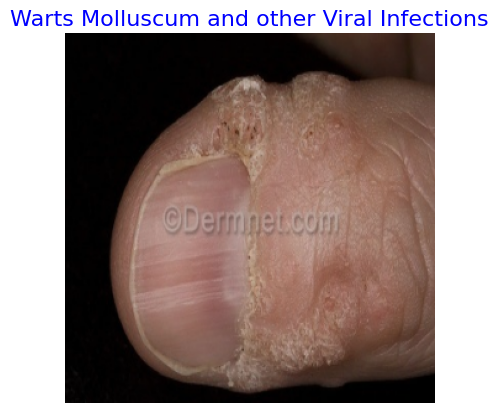

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Atopic Dermatitis Photos/05Atopic040504.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['05Atopic040504.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Atopic Dermatitis
Probability:  96.46 %



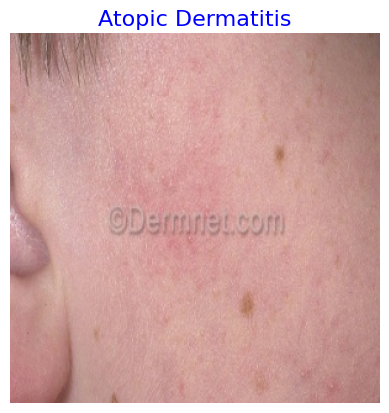

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Seborrheic Keratoses and other Benign Tumors/seborrheic-keratoses-ruff-100.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['seborrheic-keratoses-ruff-100.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 3s 3s/step
Class: Seborrheic Keratoses and other Benign Tumors
Probability:  79.82 %



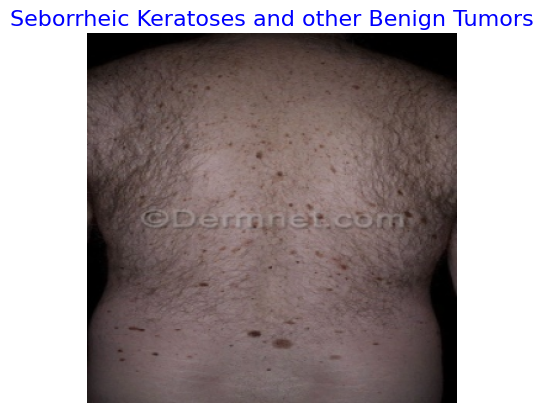

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/test/Tinea Ringworm Candidiasis and other Fungal Infections/13TineaIncognito2.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['13TineaIncognito2.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Tinea Ringworm Candidiasis and other Fungal Infections
Probability:  98.57 %



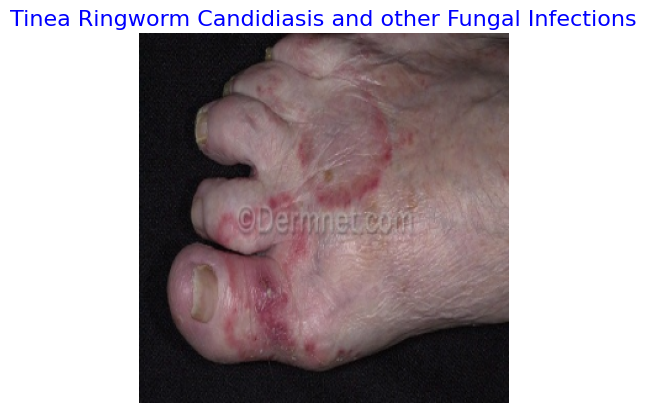

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [ ]:
working_dir=r'./'
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
img_path=r'/content/gdrive/MyDrive/data/IMG_CLASSES/4. Basal Cell Carcinoma (BCC) 3323/ISIC_0024331.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
print (os.listdir(store_path))

['ISIC_0024331.jpg']


Model is getting loaded - this will take some time
1/1 [==============================] - 2s 2s/step
Class: Basal Cell Carcinoma
Probability:  64.95 %



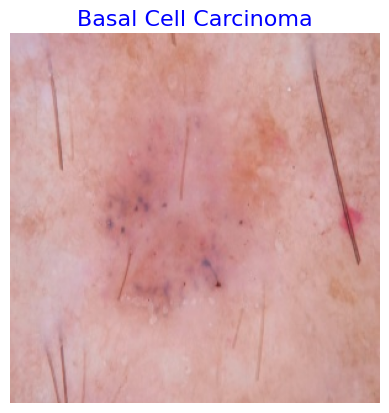

In [ ]:
csv_path="/content/gdrive/MyDrive/disease_names.csv"
model_path="/content/gdrive/MyDrive/EfficientNetB3-skin disease-83.83.h5"
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False)
if(class_name==""):
  msg=f'Disease could not be detected!'
else:
  msg=f'Class: {class_name}\nProbability: {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))